<a href="https://colab.research.google.com/github/nicknovoa03/Stock-trader/blob/Nick-Dev/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Unzip stock  to have access to files in notebook enviorment
  * using in google colab


In [0]:
import zipfile

zname = 'stocks.zip'

with zipfile.ZipFile(zname,'r') as zip_ref:
  zip_ref.extractall()

##Import all information from quotes from their .csv's
* 'date', 'open', 'high', 'low', 'close', 'adjclose', 'volume' for each stock

In [0]:
import numpy as np
import pandas as pd
from statistics import mean
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# All lists and Dictionaries ordered from most recent to oldest
allData = {}
close = {}
closeDF = {}

# Date,Open,High,Low,Close,Adj Close,Volume
# 1980-12-12,0.513393,0.515625,0.513393,0.513393,0.023007,117258400
# 1980-12-15,0.488839,0.488839,0.486607,0.486607,null,43971200
# ...
dirpath = 'stocks/quotes'
for file in os.listdir(dirpath):
    symbol = os.path.splitext(file)[0]
    if symbol[0] == '.':
      continue
    #print('Stock:',symbol)
    path = dirpath + '/' + file
    dt = {'names':('date','open','high','low','close','adjclose','volume'),
        'formats':('U10',np.float, np.float, np.float, np.float, np.float, np.float)}
    
    npdata = np.genfromtxt(path, skip_header=1, dtype=dt, delimiter=',')
    
    closeDF[symbol] = pd.DataFrame({symbol : npdata['close']},index=npdata['date']) 
    allData[symbol] = npdata


##Calculate Small Moving Averages using Pandas
 * return a dictionay where each key is the symbol and the value is a pandas DataFrame with the moving average for that day

In [0]:
def calcSMA(period):
  temp = {}
  start = 0
  sma = 0
  for sym,val in closeDF.items():
    #check if length of all closing values is bigger than the period
    if val.size-period < 0:
      print(val,"closing array length of:",val.size,"...expected ~",start+period-1)
      continue
    #get the SMA for each stock with pandas
    sma = val.rolling(window=period).mean()
    #Add to temp dictionary with key being the symbol and value is SMA
    temp[sym] = sma
  return temp


In [0]:
sma50 = calcSMA(50)
#print("sma50 = %s" %sma50)
#print("Sma50 Length = %d" %len(sma50))

sma10 = calcSMA(10)
#print("sma10 = %s" %sma10)
#print("Sma10 Length = %d" %len(sma10))

sma100 = calcSMA(100)


##Plot closing prices with SMA of 50 and 100 days

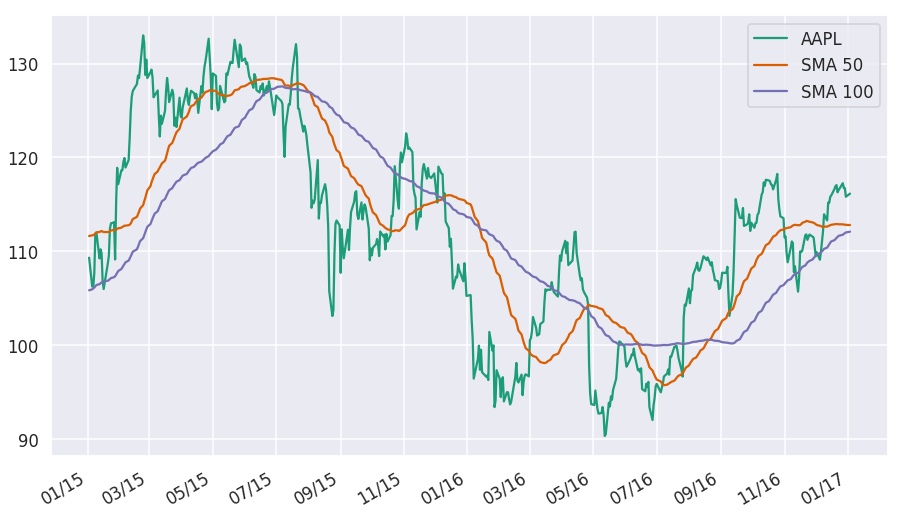

In [123]:
symbol = 'AAPL'
sd = '2015-01-01'
ed = '2017-01-03'

my_year_month_fmt = mdates.DateFormatter('%m/%y')

#concatinate dataframes
df = closeDF[symbol]
smas = sma50[symbol]
smab = sma100[symbol]
df = pd.concat([df,smas],axis=1)
df = pd.concat([df,smab],axis=1)
df.columns = [symbol,'SMA 50','SMA 100']

#change index to datetime format from str
df.index = pd.to_datetime(df.index)
#plot date
fig, ax = plt.subplots(figsize=(15,9))
df.loc[sd:ed,:].plot(ax=ax)

#set ticks every day
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(my_year_month_fmt)

##calculate the Exponential Moving Average 
* return a dictionay where each key is the symbol and the value is a pandas DataFrame with the exponential moving averages for each day

In [124]:
#just a quick demo to show how the EMA is returned in the dataframe
apl = closeDF['AAPL']
ema = apl.ewm(span = 20,adjust=False).mean()
ema.tail()

,AAPL
2019-03-29,184.384892
2019-04-01,185.037760
2019-04-02,185.893212
2019-04-03,186.793859
2019-04-04,187.641111


In [0]:
def calcEMA(period):
  temp = {}
  start = 0
  ema = 0
  for sym,val in closeDF.items():
    #check for valid length of val array
    if val.size-period < 0:
      print(val,"closing array length of:",val.size,"...expected ~",start+period-1)
      continue
    #get the EMA using pandas
    ema = val.ewm(span = period, adjust = False).mean()
    #add to dictionary with key being the symbol and value is a pandas DataFrame
    temp[sym] = ema
  return temp

ema50 = calcEMA(50)
#print("sma50 = %s" %sma50)
#print("Sma50 Length = %d" %len(sma50))

ema100 = calcEMA(100)
#print("ema10 = %s" %ema10)
#print("ema10 Length = %d" %len(ema10))

ema20 = calcEMA(20)

##Plot closing prices with EMA and SMA

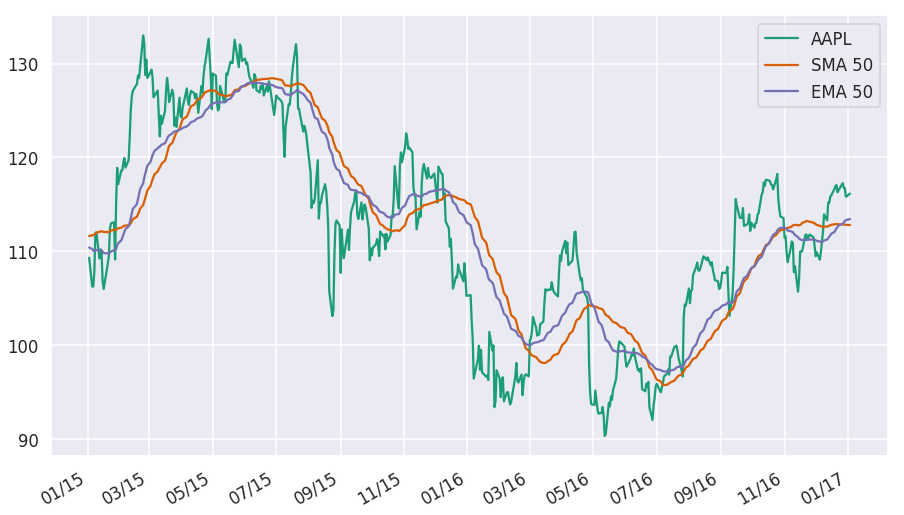

In [126]:
symbol = 'AAPL'
sd = '2015-01-01'
ed = '2017-01-03'

my_year_month_fmt = mdates.DateFormatter('%m/%y')

#concatinate dataframes
df = closeDF[symbol]
smas = sma50[symbol]
emas = ema50[symbol]
df = pd.concat([df,smas],axis=1)
df = pd.concat([df,emas],axis=1)
df.columns = [symbol,'SMA 50','EMA 50']

#change index to datetime format from str
df.index = pd.to_datetime(df.index)
#plot date
fig, ax = plt.subplots(figsize=(15,9))
df.loc[sd:ed,:].plot(ax=ax)

#set ticks every day
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [128]:
dydxAvg = 0
dydx2Avg = 0
dydxList = []
dydx2List = []

def CalcDydx(l):
    global dydxList
    global dydxAvg
    dx = 1
    dydxList = list(numpy.diff(smaList) / dx)
    dydxAvg = mean(dydxList)

def calcDydx2():
    global dydx2List
    global dydx2Avg
    dx = 1
    dydx2List = list(numpy.diff(dydxList) / dx)
    dydx2Avg = mean(dydx2List)


CalcDydx()
print("Dydx Length=%d" %len(dydxList))
print("Dydx2 Length=%d" %len(dydx2List))
printList(dydxList, "dy/dx List")
printList(dydx2List, "d2y/dx2 List")

TypeError: ignored

In [0]:
#  (12 * (p0 / p1 – 1))
# + (4 * (p0 / p3 – 1))
# + (2 * (p0 / p6 – 1))
# +      (p0 / p12 – 1)
# Where p0 = the asset price at today’s close, 
# p1 = the asset price at the close of the previous month, etc.

today = datetime.datetime.today().strftime('%Y/%m/%d')
momentum = [0 for x in range(0,4)]
confidence = 0

def dayDif(d1, d2):
    d1 = datetime.strptime(d1, '%Y/%m/%d')
    d2 = datetime.strptime(d2, '%Y/%m/%d')
    return abs((d2 - d1).days)
    
def calcMomentum():
    global momentum
    p0=0.0; p1=0.0; p3=0.0; p6=0.0; p12=0.0
    months = ['12','11','10','09','08','07','06','05','04','03','02','01','12','11','10','09','08','07','06','05','04','03','02','01']
    p0_mn = dateList[0][5:7] # current month
    p1_mn = months[months.index(p0_mn)+1]
    p3_mn = months[months.index(p0_mn)+3]
    p6_mn = months[months.index(p0_mn)+6]
    p12_mn = months[months.index(p0_mn)+12]
    
    #print("p0_mn=%s, p1_mn=%s, p3_mn=%s, p6_mn=%s, p12_mn=%s" %(p0_mn,p1_mn,p3_mn,p6_mn,p12_mn))
    for d in dateList:
        dates = d.split("/")
        if dates[1] == p0_mn and p0 == 0:
            p0 = float(closeDic[d])
            #print("%s : p0=%f\n" %(d,p0))
        elif dates[1] == p1_mn and p1 == 0:
            p1 = float(closeDic[d])
            #print("%s : p1=%f\n" %(d,p1))
        elif dates[1] == p3_mn and p3 == 0:
            p3 = float(closeDic[d])
            #print("%s : p3=%f\n" %(d,p3))
        elif dates[1] == p6_mn and p6 == 0:
            p6 = float(closeDic[d])
            #print("%s : p6=%f\n" %(d,p6))
        elif dates[1] == p12_mn and p12 == 0 and p6 != 0: 
            p12 = float(closeDic[d])
            #print("%s : p12=%f\n" %(d,p12))
            break
    
    #print("p0=%f, p1=%f, p3=%f, p6=%f, p12=%f" %(p0,p1,p3,p6,p12))
    momentum[0] = 12 * (p0 / p1 - 1)
    momentum[1] = 4 * (p0 / p3 - 1)
    momentum[2] = 2 * (p0 / p6 - 1)
    momentum[3] = 1 * (p0 / p12 - 1)
    print("momentum[0]=%f \nmomentum[1]=%f \nmomentum[2]=%f\nmomentum[3]=%f" %(momentum[0],momentum[1],momentum[2],momentum[3]))
    confidence = momentum[0] + momentum[1] + momentum[2] + momentum[3]
    return confidence


print("Today is %s" %today)
confidence = calcMomentum()
print("Confidence: %f" %confidence)
#printDateList()
printList(momentum, "Momentum List")

In [0]:
ema10List = [None for x in closeList]
ema10Dic = {}


# starts from bottom of list
def calcEMA(start, period, emaList, emaDic,smaList):
    if period == 10: smaList = sma10List
    elif period == 50: smaList = sma50List
    
    print("params: %d, %d - " %(start,period))
    if start == 0:
        return
    if start > len(closeList)-period-1:
        print(start)
        print(len(smaList))
        #print(smaList[start])
        emaList.insert(start,smaList[start])
        emaDic[dateList[start]] = smaList[start]
    else:
        smoothing = 2 / (period + 1)
        w = smoothing / (period + 1)
        #print(len(emaList))
        ema = (closeList[start] * w) + (emaList[start+1] * (1 - w))
        #print("EMA=%f - " %ema, end="")
        if ema != 0:
            emaList.insert(start,ema)
            emaDic[dateList[start]] = ema
        #print(emaList[start])
    calcEMA(start-1,period,emaList,emaDic,smaList)
    return emaList,emaDic

'''
def calcSMA(start, period, smaList, smaDic):
    if start+period-1 == len(closeList):
        return
    sma = mean(closeList[start:period+start])
    smaList.insert(start,sma)
    smaDic[dateList[start+period-1]] = sma
    calcSMA(start+1, period, smaList, smaDic)
    return smaList, smaDic
'''

ema10List,ema10Dic = calcEMA(len(closeList)-1,10,ema10List,ema10Dic,sma10List)
#ema10List = calcEMA2(len(closeList)-1,10,ema10List,ema10Dic)
#ema10List = ema10List.reverse()
#printDic(ema10Dic, "EMA 10 Dictionary")

In [0]:
legendList = ["Close", "50-day SMA", "10-day SMA ","EMA"]

def graph(*args): 
    i = 0 
    for arg in args:
        #arg = scale(arg)
        x = [z for z in range(0,len(arg))]
        y = []
        for v in arg:
            y.append(float(v))
        y.reverse()
        plt.plot(x,y,label=legendList[i])
        i += 1
def plotGraph(): 
    plt.figure(figsize=(12,7)) 
    plt.style.use('seaborn-white') 
    tmp = list(ema10Dic.values())
    print(tmp)
    graph(sma50List,sma10List,closeList,tmp)
    plt.title("Apple")
    plt.ylabel("Price")
    plt.xlabel("Days")
    plt.legend(loc = 1, frameon = True, fancybox = True, shadow = True)    
    plt.show()

plotGraph()